# **Correlation Study**

## Objectives

* Identify variables with most significant correlation to the sale price 
to answer the first business requirement.

## Inputs

* outputs/datasets/cleaned/FullSetCleaned.csv

## Outputs

* Explanations of analysis and visualisations to back up strategic approach.

## Crisp-DM

* Data Understanding


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/house-prices-ml/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/house-prices-ml'

# Load Data

Load data and display head to check that it has been loaded.

In [4]:
import pandas as pd
df_sales = pd.read_csv("outputs/datasets/cleaned/FullSetCleaned.csv")
print("Sales Data")
df_sales.head()


Sales Data


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,864,0.0,3.0,No,432,ALQ,432,0.0,0,none,...,70.0,0.0,0,5,4,864,0.0,1971,1971,115000
1,864,0.0,3.0,No,398,ALQ,317,0.0,720,RFn,...,60.0,0.0,0,8,5,864,0.0,1950,2002,129000
2,840,828.0,3.0,No,0,none,840,0.0,500,RFn,...,72.0,101.0,68,5,7,840,0.0,2003,2003,180000
3,990,1611.0,4.0,No,0,Unf,612,0.0,621,RFn,...,51.0,0.0,0,6,5,612,0.0,1921,1998,189000
4,1496,636.0,1.0,Gd,1441,GLQ,55,0.0,612,Fin,...,79.0,0.0,40,8,8,1496,349.0,1983,2009,316600


---

# Dataset Analysis 

We will look again at the pandas profile report, this time with the cleaned data and no missing values. 

In [ ]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=df_sales, minimal=True)
pandas_report.to_notebook_iframe()

### Observations from profiling


Our data has 4 categorical variables which must be converted to a numerical data type values to facilitate the correlation calculations.

For this we will use the OneHotEncoder function.

In [ ]:
from feature_engine.encoding import OneHotEncoder
encoder = OneHotEncoder(variables=df_sales.columns[df_sales.dtypes=='object'].to_list(), drop_last=False)
df_ohe = encoder.fit_transform(df_sales)
print(df_ohe.shape)
df_ohe.head(5)


As expected, our dataset now has additional columns (total of 40). This is due to OneHotEncoder translating each category into its own column, and assigning a value of 1 or 0. A value of 1 means the property has this category. 

### Correlation Functions

Now we use the corr() function with spearman and pearson methods to determine which variables warrant further investigation.


In [ ]:
corr_spearman = df_ohe.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_spearman

In [ ]:
corr_pearson = df_ohe.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_pearson

Now we combine the outputs, adding the two correlation values for a single result to evaluate.

In [ ]:
combined_corr = corr_spearman.add(corr_pearson, fill_value=0)

# Convert to DataFrame and sort by total correlation value
combined_corr = combined_corr.sort_values(ascending=False)

print(combined_corr)

From here we will choose the top 6 variables for further analysis as the 4th, 5th and 6th in the list are very closely rated from our correlation calculations. 

In [8]:
vars_to_study = [
    'GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF','YearBuilt',
    'OverallQual']


### Bivariate study

We will use scatter plots and box plots to visualise the relationships between our variables and the sale price. We will save the visualisations to display them on the dashboard.


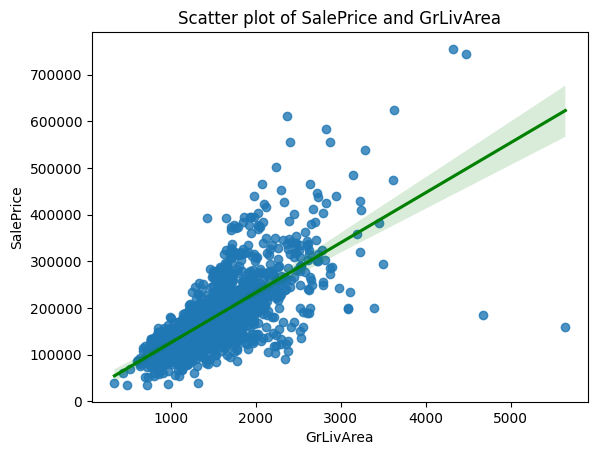

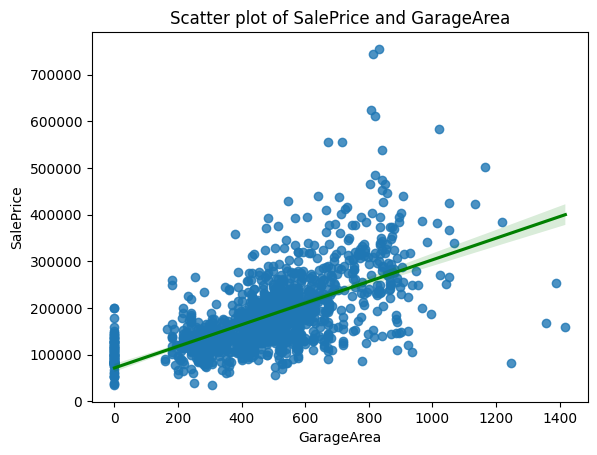

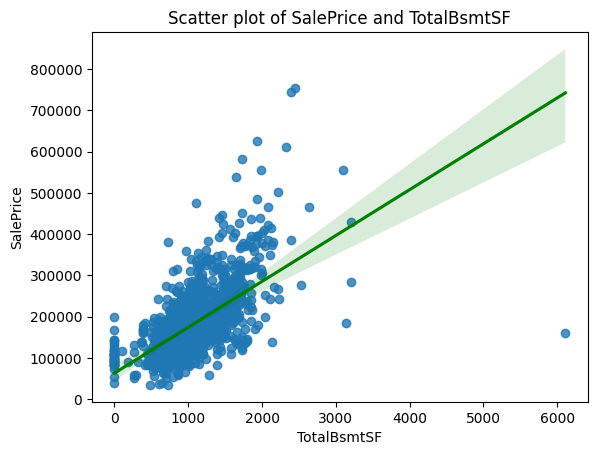

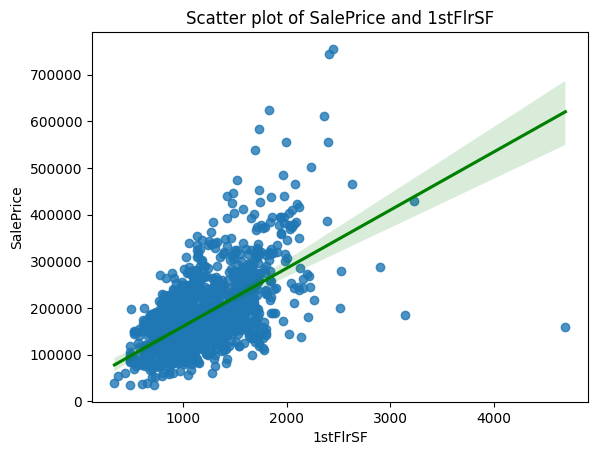

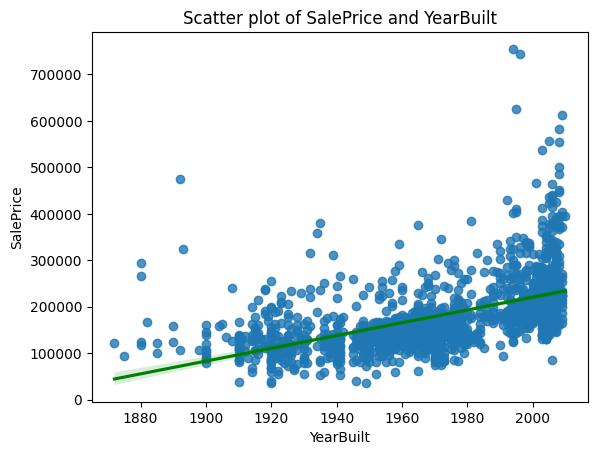

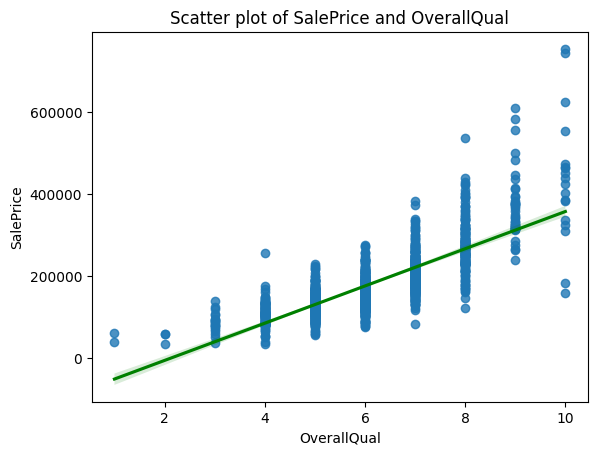

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

for category in vars_to_study:
    plt.figure()
    sns.regplot(x=category, y="SalePrice", data=df_sales, line_kws={"color": "green"}).set(
        title=f'Scatter plot of SalePrice and {category}')
    

[Text(0.5, 1.0, 'Box plot of SalePrice and OverallQual')]

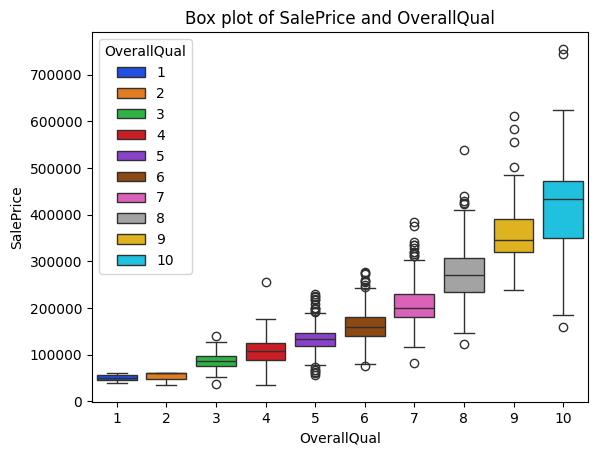

In [7]:
plt.figure()
sns.boxplot(x="OverallQual", y="SalePrice", hue="OverallQual", data=df_sales, palette="bright").set(
    title="Box plot of SalePrice and OverallQual")

### Observations

* 'GrLivArea' - The plot shows a positive correlation between GrLivArea and SalePrice.
* 'GarageArea' - The plot shows a positive correlation between GarageArea and SalePrice. There are outliers at the top end of the plot showing the properties with the largest garage areas do not have a high sale price.
* 'TotalBsmtSF' - The plot shows a very clear correlation between TotalBsmtSF and SalePrice. The higher the TotalBsmntSF value, the higher saleprice we can expect.
* '1stFlrSF' - The high correlation between SalePrice and 1stFlrSF is reflected in the graph.
* 'YearBuilt' - The scatter plot of Sale Price and Year Built shows the correlation and upward trend, with newer houses (built most recently) typically having a higher sale price.
* 'OverallQual' - The scatter and box plots show a strong correlation between the overall quality of the house to the sale price. We can also see that houses with the highest quality rating have the greatest variance in sale price.

---

## Hypothesis Testing

### Hypothesis 1

<strong>1: Larger houses have a higher sale price than smaller houses (area)
</strong>

To test this hypothesis we will consider all variables concerned with area.
GrLivArea, GarageArea, 1stFlrSF.

We will plot scatter graphs of each variable against the target variable 
SalePrice to visualise the correlation.

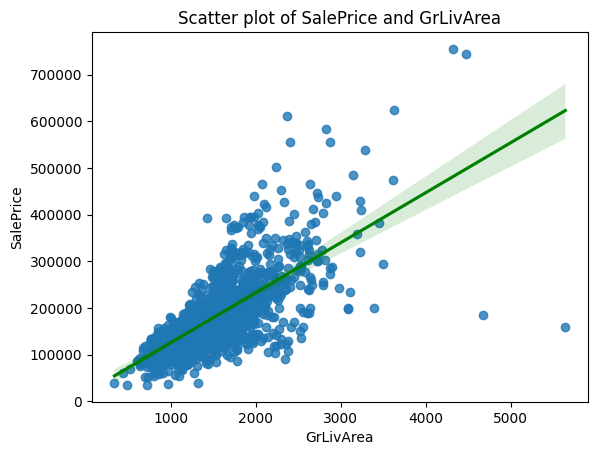

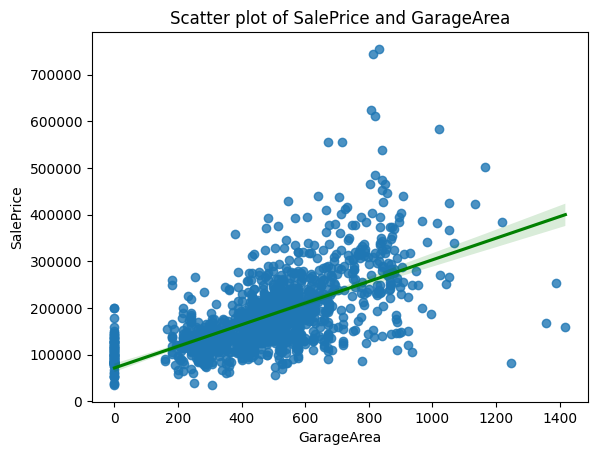

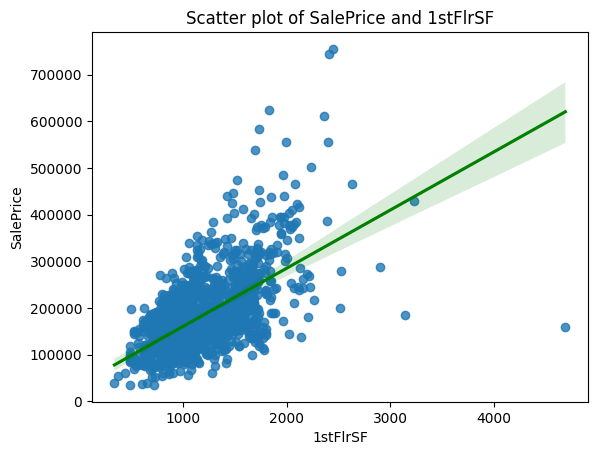

In [13]:
hypothesis_vars = ['GrLivArea', 'GarageArea', '1stFlrSF']
for category in hypothesis_vars:
    plt.figure()
    sns.regplot(
        x=category, y="SalePrice", data=df_sales, line_kws={"color": "green"}).set(
        title=f'Scatter plot of SalePrice and {category}')

The above plots show there is a positive relationship between SalePrice and each 
of the variables 'GarageArea', 'GrLivArea', 'TotalBsmtSF'. As the area increases
so does the house price. 

<strong>Conclusion: </strong>The hypothesis is proved true - larger houses do command higher sale prices.


### Hypothesis 2

<strong>2: Newer houses, and recently remodelled / improved houses are more expensive than older houses.</strong>

To test this hypothesis we will consider both variables concerned with years / time -
'YearBuilt' and 'YearRemodAdd'.

We will plot scatter graphs of both variables against the target variable 
SalePrice to visualise the correlation. 

[Text(0.5, 1.0, 'Scatter plot of SalePrice and YearBuilt')]

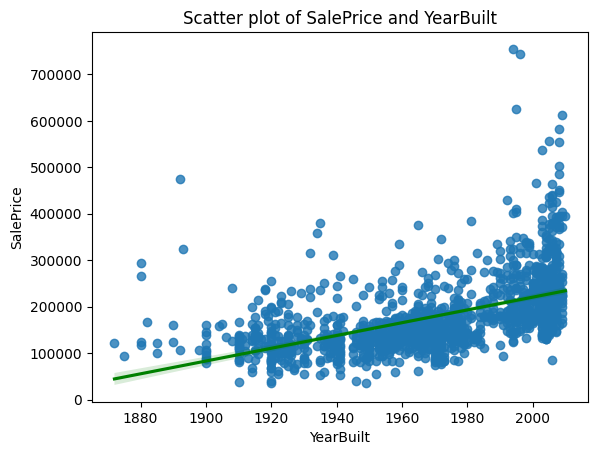

In [16]:
plt.figure()
sns.regplot(
        x='YearBuilt', y="SalePrice", data=df_sales, line_kws={"color": "green"}).set(
        title=f'Scatter plot of SalePrice and YearBuilt')

[Text(0.5, 1.0, 'Scatter plot of SalePrice and YearRemodAdd')]

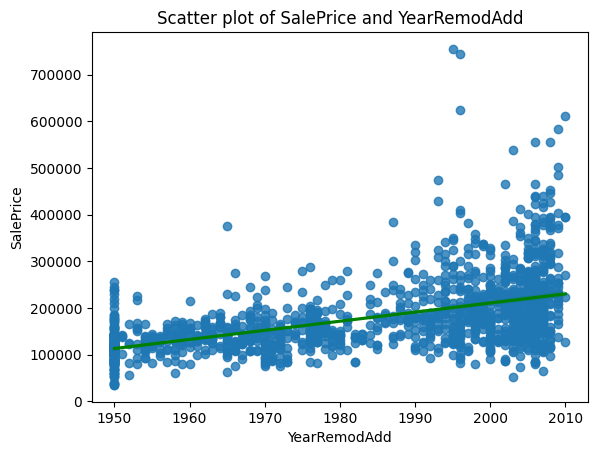

In [18]:
plt.figure()
sns.regplot(
        x='YearRemodAdd', y="SalePrice", data=df_sales, line_kws={"color": "green"}).set(
        title=f'Scatter plot of SalePrice and YearRemodAdd')

The above plots show there is a positive correlation between SalePrice and each 
of the variables 'YearBuilt' and 'YearRemodAdd'. There is a noticable 
correlation between both variables that prove the hypothesis is true.

<strong>Conclusion: </strong>
The hypothesis is proved true - newer houses are more expensive than older houses.

### Hypothesis 3

<strong>Houses in the best condition command the highest prices.</strong>

To test this hypothesis we will consider the variable describing the overall 
condition of the house - 'OverallCond'. We are not concerend with the quality
of the house for this hypothesis, only the condition of the house.


We will use a boxplot to show the house conditions against the target variable 
to visualise the correlation. 


/tmp/ipykernel_3432/721840622.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="OverallCond", y="SalePrice", hue=None, data=df_sales, palette="bright").set(


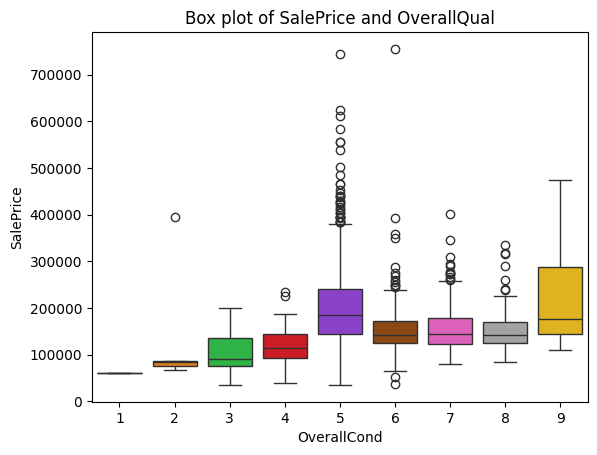

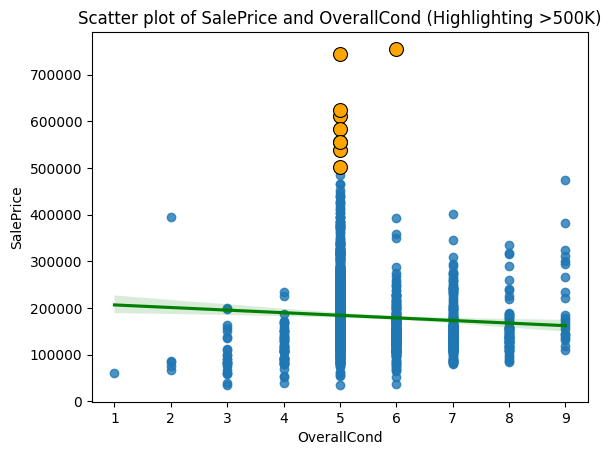

In [26]:
plt.figure()
sns.boxplot(x="OverallCond", y="SalePrice", hue=None, data=df_sales, palette="bright").set(
    title="Box plot of SalePrice and OverallQual")

plt.figure()
sns.regplot(
        x='OverallCond', y="SalePrice", data=df_sales, line_kws={"color": "green"}).set(
        title=f'Scatter plot of SalePrice and OverallCond')

df_filtered = df_sales[df_sales["SalePrice"] > 500000]
sns.scatterplot(
    x=df_sales[df_sales["SalePrice"] > 500000]["OverallCond"], 
    y=df_sales[df_sales["SalePrice"] > 500000]["SalePrice"], 
    color="orange",  # Highlight points orange
    edgecolor="black",    
    s=100,  # Increase marker size for emphasis
    )
plt.title('Scatter plot of SalePrice and OverallCond (Highlighting >500K)')
plt.show()

The above plots show the houses with the highest sale prices are not those in 
the best condition. There is a slight negative correlation between SalePrice
and OverallCond. Houses with the best rating for overallcondition have not
sold for over 500,000 USD. Many houses with an overallcond rating of 5 have 
a sale price in excess of 500,000 USD. An overall condition rating of 5 is the 
entry point for the highest sale prices.

<strong>Conclusion: </strong>
The hypothesis is proved false - houses with the highest sale prices are not those in 
the best condition. 

## Conclusions

To summarise the analysis above, we can conclude:

* Typically, larger houses have a higher sale price.
* Typically, newer houses have a higher sale price.
* The quality of the house correlates positively with the sale price.
* An overall condition rating of at least 5 is required to achieve the highest sale prices.
